In [42]:
import os
import cv2
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, Subset
from torch import optim
import torchvision
from torchvision.transforms.functional import to_tensor, to_pil_image
from sklearn.model_selection import ShuffleSplit
from PIL import Image
from albumentations import HorizontalFlip, VerticalFlip, Compose, Resize
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries


In [ ]:
!pip install torchsummary

In [5]:
# Path to the training dataset
training_data_path = '/kaggle/input/final-data/kaggle/working/training_set'

# List of images (excluding annotations)
image_list = [file for file in os.listdir(training_data_path) if "Annotation" not in file and (file.endswith(".jpg") or file.endswith(".png"))]

# List of annotation files
annotation_list = [file for file in os.listdir(training_data_path) if "Annotation" in file]

# Print the number of images and annotations
print("Number of images:", len(image_list))
print("Number of annotations:", len(annotation_list))


Number of images: 526
Number of annotations: 526


In [4]:
anntsList[0]

'245_HC.png'

# Randomly select some images to check

In [11]:
# Function to fit ellipse and extract coordinates
def fit_ellipse_and_get_coordinates(image_path, mask_path):
    image_name = os.path.basename(image_path)
    mask_name = os.path.basename(mask_path)
    image_name = image_name.replace("_Annotation", "")  # Remove "_Annotation" from image name
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # print(f"contours is {contours}\n")
    
    ellipse_data = []
    for contour in contours:
        if len(contour) >= 5:  # Minimum points required for fitting ellipse
            ellipse = cv2.fitEllipse(contour)
            (x, y), (major, minor), angle = ellipse
            
            # Extracting coordinates
            x1 = int(x + major * np.cos(np.radians(angle)) / 2)
            y1 = int(y + major * np.sin(np.radians(angle)) / 2)
            x2 = int(x - major * np.cos(np.radians(angle)) / 2)
            y2 = int(y - major * np.sin(np.radians(angle)) / 2)
            x3 = int(x + minor * np.cos(np.radians(angle + 90)) / 2)
            y3 = int(y + minor * np.sin(np.radians(angle + 90)) / 2)
            x4 = int(x - minor * np.cos(np.radians(angle + 90)) / 2)
            y4 = int(y - minor * np.sin(np.radians(angle + 90)) / 2)
            
            ellipse_data.append([image_name, x, y, x1, y1, x2, y2, x3, y3, x4, y4])
    
    return ellipse_data

# Folder containing images and masks
folder_path = "/kaggle/input/origin-health/orig_health/Task - Segmentation/images"

# Iterate through images and masks
ellipse_results = []
for filename in os.listdir(folder_path):
    if filename.endswith(".png") and "_Annotation" in filename:
        mask_path = os.path.join(folder_path, filename)
        image_name = filename.replace("_Annotation", "")  # Get image name from mask name
        image_path = os.path.join(folder_path, image_name)
        ellipse_data = fit_ellipse_and_get_coordinates(image_path, mask_path)
        ellipse_results.extend(ellipse_data)

# Create DataFrame and save to CSV
columns = ["Image Name", "Center X", "Center Y", "Major X1", "Major Y1", "Major X2", "Major Y2", "Minor X1", "Minor Y1", "Minor X2", "Minor Y2"]
df = pd.DataFrame(ellipse_results, columns=columns)
df.to_csv("ellipse_coordinates.csv", index=False)


In [12]:
df.head()

,Image Name,Center X,Center Y,Major X1,Major Y1,Major X2,Major Y2,Minor X1,Minor Y1,Minor X2,Minor Y2
0,492_HC.png,367.201263,270.481171,381,467,353,73,108,288,625,252
1,237_2HC.png,406.227905,287.113220,415,481,396,92,154,299,658,274
2,244_HC.png,388.286621,218.584641,437,387,338,49,188,277,588,159
3,310_HC.png,408.133728,260.184784,388,460,428,60,163,235,652,284
4,259_HC.png,381.607147,278.902100,374,481,388,76,103,269,659,288


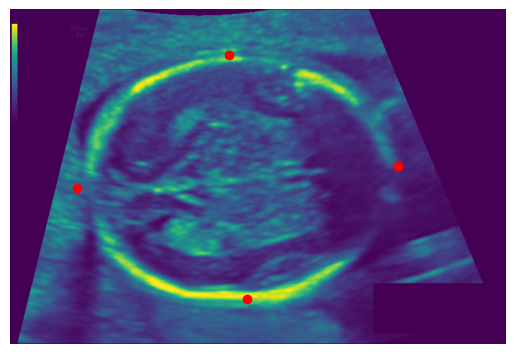

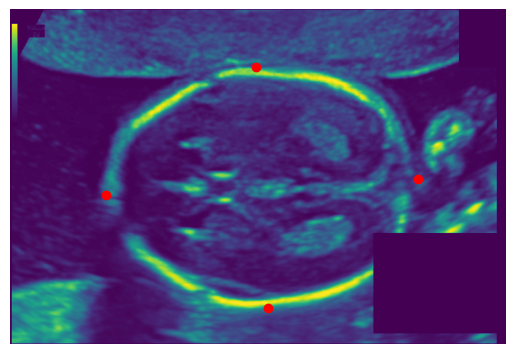

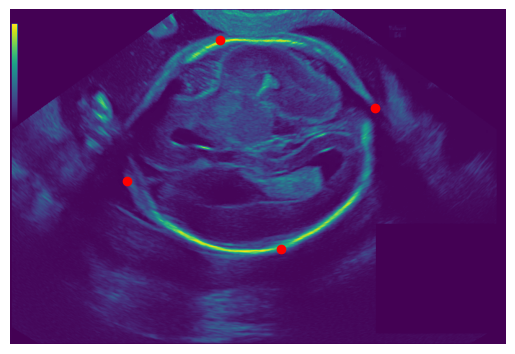

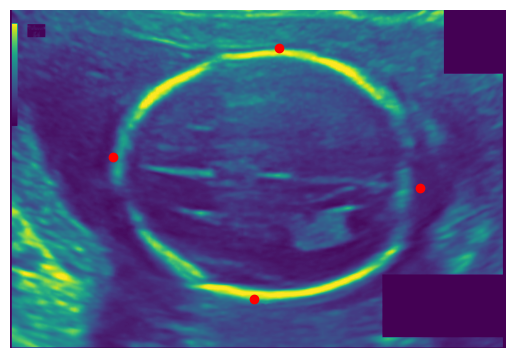

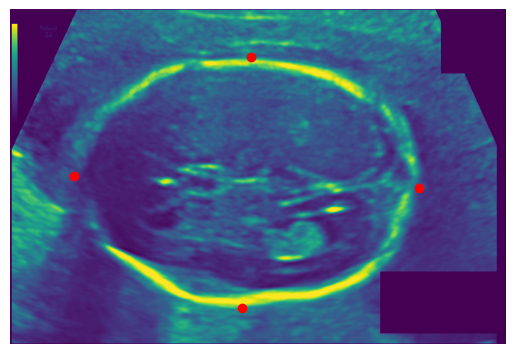

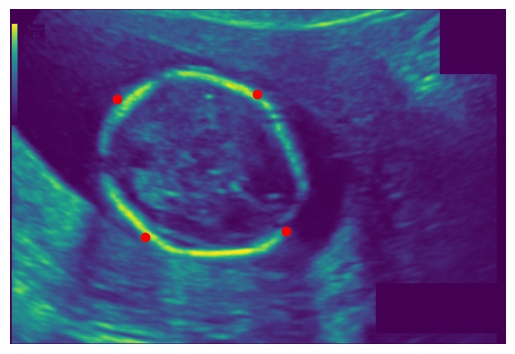

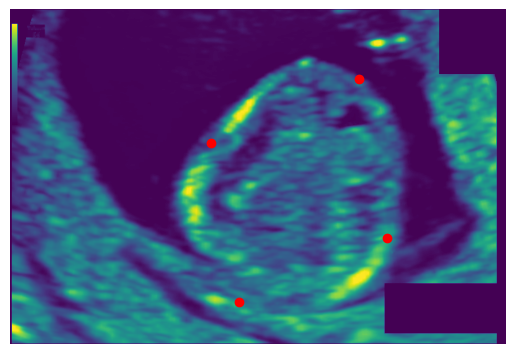

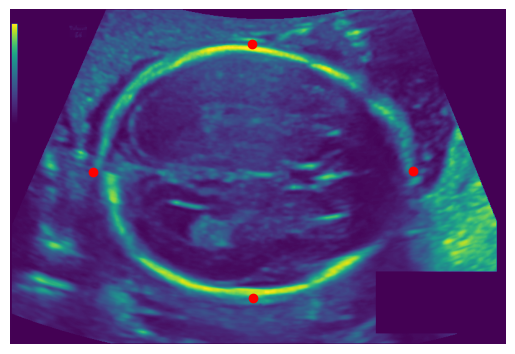

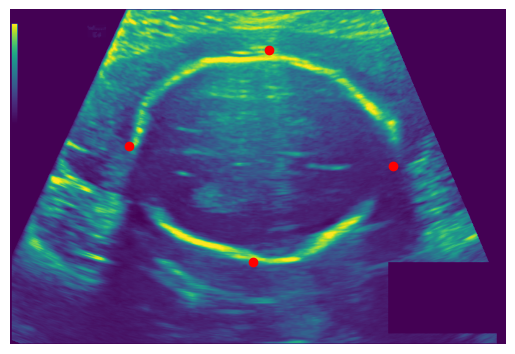

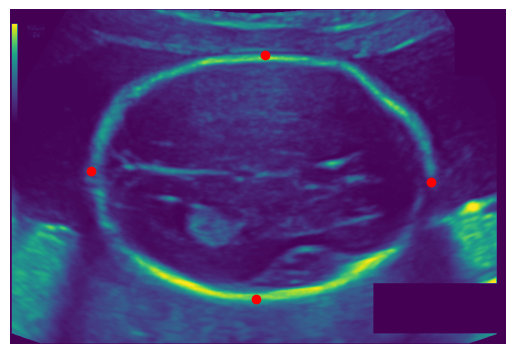

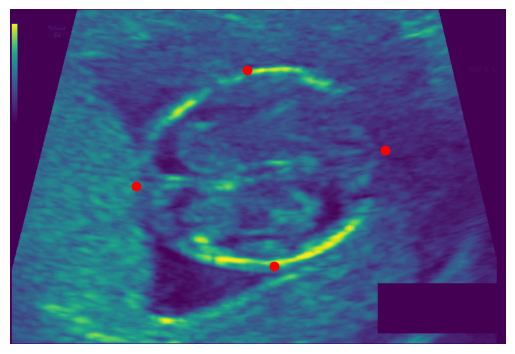

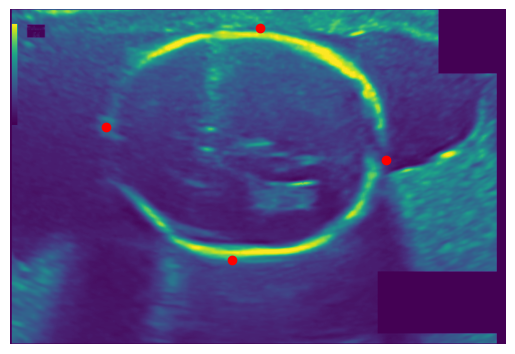

In [13]:

# Load the CSV file containing ellipse coordinates
df = pd.read_csv("/kaggle/working/ellipse_coordinates.csv")


def plot_points(row):
    # Read the image
    image_path = "/kaggle/input/origin-health/orig_health/Task - Segmentation/images/" + row["Image Name"]  # Adjust this path accordingly
    image = plt.imread(image_path)
    
    # Plot the image
    plt.imshow(image)
    
    # Plot the points
    plt.plot(row["Major X1"], row["Major Y1"], 'ro')  # Plotting major axis points
    plt.plot(row["Major X2"], row["Major Y2"], 'ro')
    plt.plot(row["Minor X1"], row["Minor Y1"], 'ro')  # Plotting minor axis points
    plt.plot(row["Minor X2"], row["Minor Y2"], 'ro')
    
    # Show the plot
    plt.axis('off')
    plt.show()    

# Iterate through the DataFrame and plot points on images
count = 0
for _, row in df.iterrows():
    plot_points(row)
    if count > 10:
        break
    count+= 1    


In [16]:

np.random.seed(2019)
rndImgs=np.random.choice(image_list,4)
rndImgs

array(['075_HC.png', '386_HC.png', '222_HC.png', '108_HC.png'],
      dtype='<U11')

## Visualize the mask on original mask

In [18]:


def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

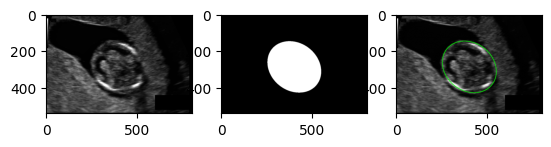

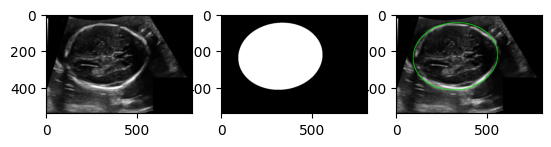

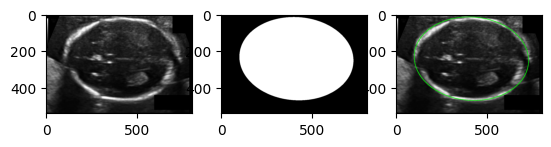

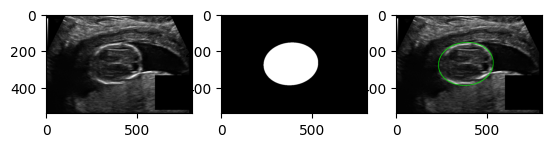

In [19]:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)        

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)

## Augmentation and resizing

In [22]:



h, w= 270, 400  # resizing to a smaller size to save GPU memory, otherwise I was not able to load a significant batch size
transform_train = Compose([ Resize(h,w), 
                HorizontalFlip(p=0.5), 
                VerticalFlip(p=0.5), 
              ])


transform_val = Resize(h,w)

## Define custom dataset function

In [23]:
from torchvision.transforms.functional import to_tensor, to_pil_image


class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):      

        imgsList = [pp for pp in os.listdir(path2data) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList] 
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)
      
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)        
        
        image= np.array(image)
        mask=mask.astype("uint8")        

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']            

        image= to_tensor(image)            
        mask=255*to_tensor(mask) 
#         print(f"image shape is {image.shape} and mask shape is {mask.shape}")
        return image, mask

In [24]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

526
526


In [25]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 270, 400]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 270, 400]) torch.FloatTensor tensor(1.)


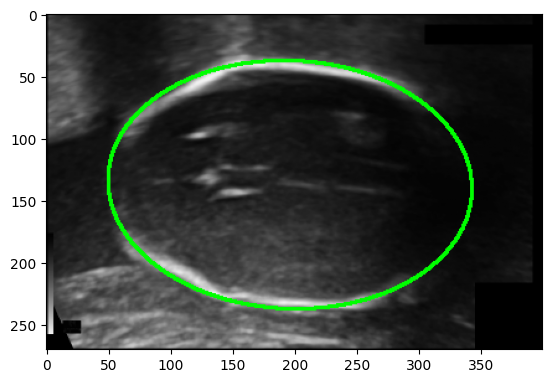

In [26]:
show_img_mask(img, mask)

In [27]:


sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

420
----------
106


In [ ]:
train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, pin_memory=True) 

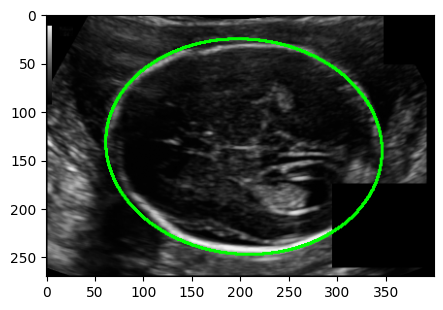

In [30]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

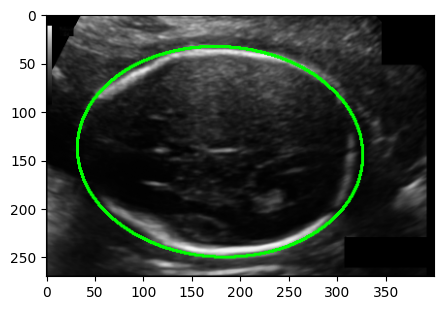

In [31]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

In [33]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 270, 400]) torch.float32
torch.Size([8, 1, 270, 400]) torch.float32


In [34]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 270, 400]) torch.float32
torch.Size([8, 1, 270, 400]) torch.float32


## Define architecture of SegNet

In [37]:
class SegNet(nn.Module):

    def __init__(self, in_chn=1, out_chn=1, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 4stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

#         #Stage 4
#         x = F.relu(self.BNEn41(self.ConvEn41(x))) 
#         x = F.relu(self.BNEn42(self.ConvEn42(x))) 
#         x = F.relu(self.BNEn43(self.ConvEn43(x)))   
#         x, ind4 = self.MaxEn(x)
#         size4 = x.size()

        

        #DECODE LAYERS
        
#         #Stage 4
#         x = self.MaxDe(x, ind4, output_size=size3)
#         x = F.relu(self.BNDe43(self.ConvDe43(x)))
#         x = F.relu(self.BNDe42(self.ConvDe42(x)))
#         x = F.relu(self.BNDe41(self.ConvDe41(x)))
        

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)



        return x

In [38]:

model = SegNet()

In [39]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [40]:
print(model)

SegNet(
  (MaxEn): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvEn11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn11): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn12): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn21): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn22): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn31): BatchNorm2d(256, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn32): Conv2d(256, 256, kernel_s

In [43]:

summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 270, 400]             640
       BatchNorm2d-2         [-1, 64, 270, 400]             128
            Conv2d-3         [-1, 64, 270, 400]          36,928
       BatchNorm2d-4         [-1, 64, 270, 400]             128
         MaxPool2d-5  [[-1, 64, 135, 200], [-1, 64, 135, 200]]               0
            Conv2d-6        [-1, 128, 135, 200]          73,856
       BatchNorm2d-7        [-1, 128, 135, 200]             256
            Conv2d-8        [-1, 128, 135, 200]         147,584
       BatchNorm2d-9        [-1, 128, 135, 200]             256
        MaxPool2d-10  [[-1, 128, 67, 100], [-1, 128, 67, 100]]               0
           Conv2d-11         [-1, 256, 67, 100]         295,168
      BatchNorm2d-12         [-1, 256, 67, 100]             512
           Conv2d-13         [-1, 256, 67, 100]         590,080
      Bat

### Define loss function

In [44]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    
    loss = bce  + dlv

    return loss

In [46]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break
    


print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))

(tensor(0.), tensor(0.))


tensor(0.)

### Define batch metrics

In [ ]:
def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    
    return metric

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

### Define optimizer

In [ ]:
opt = optim.Adam(model.parameters(), lr=3e-4)

### Define learning rate scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

### Define loss for a epoch

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

### Training

In [ ]:
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   
        
        start_time = time.time()
        
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        epoch_time = time.time() - start_time
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("Epoch Time: %.2f seconds".format(epoch_time))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        

### Initialize training parameters

In [ ]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 50,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

In [ ]:
# torch.save(model.state_dict(), 'segnet_model.pth')
path2weights="/kaggle/input/segnet-saved-model/segnet_model.pth"
model.load_state_dict(torch.load(path2weights))
model.eval()

# Plot losses and accuracy

In [ ]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.savefig("segnet_train_val_loss_plot.png")
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), [x.cpu() for x in metric_hist["train"]], label="train")
plt.plot(range(1, num_epochs+1), [x.cpu() for x in metric_hist["val"]], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("segnet_train_val_acc_plot.png")
plt.show()


In [ ]:
path2test="/kaggle/input/final-data/kaggle/working/test_set"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
print("number of images:", len(imgsList))

In [ ]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,10)
rndImgs

In [ ]:
from torchvision.transforms.functional import to_tensor, to_pil_image
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w,h))
    img_t = to_tensor(img).unsqueeze(0).to(device)

    pred = model(img_t).cpu()
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0] >= 0.5)

    # Fit an ellipse to the predicted mask
    contours, _ = cv2.findContours(mask_pred.numpy().astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(max_contour)
        major_radius = ellipse[1][0] / 2
        minor_radius = ellipse[1][1] / 2

    # Load actual mask
    path2annt = path2img.replace(".png", "_Annotation.png")
    annt_edges = Image.open(path2annt)
    mask_actual = ndi.binary_fill_holes(annt_edges)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1) 
    plt.imshow(img, cmap="gray")
    plt.title('Original Image')

    plt.subplot(1, 5, 2) 
    plt.imshow(mask_pred, cmap="gray")
    plt.title('Predicted Mask')

    plt.subplot(1, 5, 3) 
    plt.imshow(mask_actual, cmap="gray")
    plt.title('Actual Mask')

    # Plot predicted ellipse with radii
    if contours:
        plt.subplot(1, 5, 4)
        plt.imshow(mask_pred, cmap="gray")
#         ellipse_patch = plt.Circle((ellipse[0][0], ellipse[0][1]), max(major_radius, minor_radius),
#                                    color='red', fill=False, linewidth=2)
#         plt.gca().add_patch(ellipse_patch)
        plt.plot([ellipse[0][0], ellipse[0][0] + major_radius * np.cos(np.radians(ellipse[2]))],
                 [ellipse[0][1], ellipse[0][1] + major_radius * np.sin(np.radians(ellipse[2]))], color='red', linestyle='--')
        plt.plot([ellipse[0][0], ellipse[0][0] - major_radius * np.cos(np.radians(ellipse[2]))],
                 [ellipse[0][1], ellipse[0][1] - major_radius * np.sin(np.radians(ellipse[2]))], color='red', linestyle='--')
        plt.plot([ellipse[0][0], ellipse[0][0] + minor_radius * np.cos(np.radians(ellipse[2] + 90))],
                 [ellipse[0][1], ellipse[0][1] + minor_radius * np.sin(np.radians(ellipse[2] + 90))], color='blue', linestyle='--')
        plt.plot([ellipse[0][0], ellipse[0][0] - minor_radius * np.cos(np.radians(ellipse[2] + 90))],
                 [ellipse[0][1], ellipse[0][1] - minor_radius * np.sin(np.radians(ellipse[2] + 90))], color='blue', linestyle='--')
        plt.title('Biometry points')
        
    plt.subplot(1, 5, 5) 
    show_img_mask(img, mask_pred)
    plt.title('Original Image with Pred Mask')    

    plt.show()


## For test set

In [ ]:
fetal_test=fetal_dataset(path2test, transform=transform_val)
test_dl = DataLoader(fetal_test, batch_size=8, shuffle=False, pin_memory=True) 

In [ ]:
model.eval()
with torch.no_grad():
    test_loss, test_metric=loss_epoch(model,loss_func,test_dl)
    
print(f"test_loss is {test_loss} and test_metric is {test_metric}")    